# PIA - Reinforcement Learning

1. RL Intro
2. Dynamic Programing
3. **Tabular Q-Learning**
4. Deep Reinforcement Learning (DQN)

## 3. Tabular Q-Learning

In this notebook you will solve the full reinforcement learning problem by implementing the well-known Q-Learning algorithm. *Full problem* means that the agent will learn from samples instead of using a world model, i.e the agent will learn to solve the task without prior knowledge.

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

Upload the complete Notebook (and an exported html version) to Ilias before the deadline. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Patrick Singer      |
| 2.         | Milos Aleksic         |

<font color="blue">
For better differentiation, all added comments from us will be marked in blue color.</font>

## Prerequisites

- The notebook is pretty self contained and includes all relevant theory. However, make sure that you have **read** and *understood* a corresponding lecture at least once! The notebook can only provide a short recap. Being prepared will help you to finish the notebook in time!
- Some good reading resources are:

    1. Johannes Maucher's [lecture on RL](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/tree/master/Slides/V12Reinforcement.pdf) - chapter 4.
    2. David Silver's course on RL: [Lecture 4](https://www.davidsilver.uk/teaching/): [Youtube](https://www.youtube.com/watch?v=PnHCvfgC_ZA), [Lecture 5](https://www.davidsilver.uk/teaching/): [Youtube](https://www.youtube.com/watch?v=0g4j2k_Ggc4).
    3. Sutton & Barto: [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter 6.4 & 6.5 (complete online pdf draft available).

## Theory

In the last notebook you have implemented **Policy Iteration** with **Dynamic Programming** as your first RL algorithm. This was an optimal solution but you will rarely see DP applied to real world problems. Even though those methods are guaranteed to converge with probability 1 to an optimal policy, they suffer from two major drawbacks.

---
### Curse of dimensionality

The first one is the so called **curse of dimensionality**, meaning that the computational requirements often grow exponentially with the number of state variables. Think of our policy array that we just created. It should be clear that this approach does not scale to a very high number of states/actions, which is the case in almost every real world problem. In such situations, even one update swipe through the entire state and action space can be computationally infeasible. Later we will see how to tackles this problem with **function approximation**.

### Planning vs. Learning

The second problem is that we have *cheated* in the last part. More precicely, we have created a **world model** from the knowledge that we had about the grid world. While this was pretty easy in our case, it is very unlikely that you have that much knowledge about a real world environment. Or, that the underlying environment dynamics are given by a very complicated probability distribution that we don't know (or just can't model). In consequence, we can not simply calculate the expectation values for $V(s)$ or $Q(s,a)$. This is not possible since the expectation sum requires the knowledge of the state transition probabilities $\mathcal{P}$ and the reward function $\mathcal{R}$. If we don't have such a model, the next best thing we can do is to simply **learn from trial an error**, e.g. by interacting with the environment and see what happens. If this limitation sounds reasonable to you, welcome to **reinforcement learning**!   

### Value based, model free RL

> In the following, we will solve the **full reinforcement learning problem** by **learning** an **estimate of the value function** from **experience**.

Now instead of *simulating* the outcome of actions through a world model, the agent has to actually **interact** with the environment in order to produce new experience, i.e. gather training data. Although we are **learning** now from this data instead of *planning* ahead, we will stay with the idea of a value function. All RL algorithms that use the concept of a value function are called **value based**. Furthermore, since we assume, and have, no model of the environment, we are in the realm of **model free** reinforcement learning.


> Note that there is also a class of so called **model based** algorithms in the RL literature. However, these algorithms **do not have or assume a perfect world model** either but instead, try to learn the underlying dynamics and transition probabilities. Sometimes, in addtion to a value function and/or policy. The general idea is then to use this **imperfect model** again to *plan ahead* and *simulate* potential outcomes of actions even though the model is not entirely correct.

<img src="./RL_pics/RL_taxonomy.png" alt="Agent-Environment-Loop" style="width: 400px;"/>

---

### Learning from Samples

Recall that within the Policy Iteration framework, we have calculated the **expected return**. We did so by decomposing the return into the immediate reward plus the discounted value of the expected next state or state-action pair. For the action-value function $Q(s,a)$ this has the form (*Bellman Expectation Equation*):

$$\begin{eqnarray} 
Q_{\pi}(s,a) &=& \mathbb{E}\Big[R_{t+1} + \gamma Q_{\pi}(S_{t+1},A_{t+1}) \mid S_t=s, A_t=a\Big] 
\end{eqnarray}$$

Since the calculation of the **expectation** $\mathbb{E}$, requires us to sum over all possible outcomes and hence, requires knowledge about the state transition probabilities $\mathcal{P}$ and the reward function $\mathcal{R}$, we can't do this anymore. Instead, we have to learn from experience produced within the agent-environment loop.

<img src="./RL_pics/AgentEnvLoop.png" alt="Agent-Environment-Loop" style="width: 400px;"/>

By interacting with the environment, an agent will produce *training data* in the form of state transition tuples $(S_t,A_t,R_{t+1},S_{t+1})$. Now instead of calculating the full expectation, we can use those tuples to calculate an **estimate of the true value function** by using them similarly to the Bellman Expectation Equation:

$$\begin{eqnarray} 
Q_{\pi}(s,a) &=& r_{t+1} + \gamma Q_{\pi}(s_{t+1},a_{t+1})
\end{eqnarray}$$

Think of the concrete $(s,a,r,s')$ tuples as distinct *samples*, drawn from the underlying probability distributions $\mathcal{P}$ and $\mathcal{R}$. If we can update $Q$ many times and with a *sufficient number* of distinct samples, our estimate will get closer to the true value function. This is the idea behind the so called **SARSA** algorithm (short for s,a,r,s',a'). However, SARSA does not apply the Bellman Expectation update directly but instead, uses a *softer* update rule. Because all Q-values are only estimates, it is better to not apply the full update $r_{t+1} + \gamma Q(s_{t+1},a_{t+1})$ but rather use it as a **target** towards which we will update the old estimate. The complete idea is thereby to **take the old estimate** $Q(s,a)$ and **update it** only **a little bit towards the difference between old and new estimate**. Formally the update rules is given by:

$$\begin{eqnarray} 
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_{t+1} + \gamma Q(s_{t+1}, a_{t+1})}_{target} - \underbrace{Q(s_t, a_t)}_{current} \right] 
\end{eqnarray}$$

where $\alpha$ is a small learning rate $0 < \alpha \leq 1$ and the full expression in square brackets is called the **TD-Error** (TD for Temporal-Difference). Such updates are called **on-policy** because the **same policy** was used to produce the sample and to choose the Q-value which to backup, i.e. to choose $a_{t+1}$ in $s_{t+1}$. Using this update rule, an agent can evaluate a given policy if it visits ~~every~~ enough state-action pairs multiple times. We can then improve the policy like in Policy Iteration and will finally arrive at an optimal policy after enough iterations.

---
### Q-Learning

As it turns out, there exists a very similar update that enables us to **improve the policy directly**. This is known as **Q-Learning**. Compare the new **target** expression to the SARSA target:

$$\begin{eqnarray} 
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a)}_{target} - \underbrace{Q(s_t, a_t)}_{current} \right] 
\end{eqnarray}$$

This is an **off-policy** update now because $r_{t+1}$ and $s_{t+1}$ are produced by the policy that we are following right now (**behavior policy**), but in the target, we always back up a Q-value according to a second, so called **target policy**, in this case a greedy **max** policy. Using such updates, we could for instance follow a random behavior policy to explore the environment (try out all states and actions) while improve at the same time with the greedy max policy. This is good because when learning from samples, it is crucial to visit *every* (ideally it should be every) state-action pair at least once, but as many times as possible in order to get a decent estimate of the value function. Evaluating such an exploration policy and improving on it at the same time (in one step), makes the update much more efficient compared to the SARSA algorithm.

However, we still need to **improve the behavior policy** over time in order to find an optimal policy. Because we are learning from samples, we first want to make sure that the agent has visited *enough* distinct state-action pairs before improving greedily. Otherwise we may ignore some potentially very good states and actions, only because the agent just has't seen them and therefore, we can't take them into account when improving the policy. On the other hand, we don't want to explore forever. This tradeoff between exploration and exploitation is know as the **exploration-exploitation** dilemma. The most common approach for balancing between these two is the **$\epsilon$-greedy policy**.

---
### E-Greedy Policy

The idea is very simple. In order to explore in the beginning and converge to an optimal policy over time, we will start with a fully random policy and slowly transition to a greedy max policy. This is what the $\epsilon$-greedy policy does. With probability $\epsilon$ select a random action, with probability $1 - \epsilon$ select the best action so far. We can now control the transition by starting with $\epsilon = 1$ and slowly decay it over $n$ time steps until we arrive at an almost fully greedy policy. Formally this can we written as:       

$$\begin{eqnarray}
a = \begin{cases}
        \text{a random action}                             & \text{ with probability } \epsilon\\
        \\
        \arg \displaystyle \max_{a \in \mathcal{A}} Q(s,a) & \text{ with probability } 1-\epsilon
    \end{cases}
\end{eqnarray}$$

*Almost* fully greddy, because we want the policy to be **greedy in the limit with infinite exploration**, which is a property that does provides us some nice convergence guarantees. In practice, this simply means that we will fix $\epsilon$ to some small value $\epsilon_n > 0$ after time step $n$.


---
## Implementation

Now that we have covered the necessary theory, let's start with the implementation of Q-Learning. Like in the last notebook, we will first implement some helper functions to keep the final loop clean and understandable. Also, as in the last notebook, we provide a set of plotting functions for you but this time, adjusted for Q-values. In addition, there is a `plot_agent` function which draws the agents current position on top of the value function or policy. Here is a list of functions that you have to provide in the following. For each, we added relevant comments right before the corresponding code cells.  

###### Provided by us:
- `plot_value_function`, `plot_policy`, `  plot_agent`, `plot_things`
- `get_current_state`, function that returns the current state of an agent given a raw observation.

###### To be implemented:
- `Q`, Q-Value function
- `choose_egreedy_action`, e-greedy policy
- `update`, Q-learning update for the value function
- basic agent-env loop
- a linear decay schedule for epsilon

Finally combine everything to the Q-Learning algorithm, i.e. implement a Q-Learning agent. :)

---

##### Plotting functions

These are almost the same functions as in the last notebook. Note that `plot_value_function` now takes an **action value function** and **recovers** the **state value function** by summing over all action values in one state. This makes the visualisation more clean. On the downside you can't directly relate those values to the policy anymore. If you want more detailed plotting, e.g. per action value, feel free to modify the code to your needs.

In addition, the policy plot now only takes the action values as argument and will plot a greedy policy from there directly. This is because we don't need to store an explicit policy anymore as you will see below.

In general, use the plotting functions as you please.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
from IPython import display
sns.set_style("darkgrid")

def plot_value_function(Q, print_values=True, show_cbar=True):
        
    # recover V from Q by summing over all action values per state
    V = np.sum(Q, axis=2)
    # V = np.max(Q, axis=2)
  
    ax = sns.heatmap(V, vmin=-1.5, vmax=1.5, annot=print_values, 
                        xticklabels=True, yticklabels=True, 
                        square=True, linewidths=.5, cbar=show_cbar,
                        cmap=sns.diverging_palette(10, 220, sep=40, n=256))  
    return ax

def plot_agent(ax, agent_state):
    # agent_state should be a tuple, e.g. (1,1) or (0,1) etc.
    col, row = agent_state[1],agent_state[0]
    ax.add_patch(patches.Rectangle((col, row), 1, 1, zorder=2))
    return ax

def plot_policy(Q, action_set, print_values=False, show_cbar=True):
    # plot the value funtion as a background
    ax = plot_value_function(Q, print_values=print_values, show_cbar=show_cbar)
    
    # plot a greedy policies actions in a quiver arrow plot
    num_rows, num_cols, num_actions = Q.shape
    
    for row in range(num_rows):
        for col in range(num_cols):
            state = (row,col)
            actions = np.where(Q[state] == max(Q[state]))[0]
            probability = 1 / len(actions)
            
            for action in actions:
                # Note that action directions and array indices are [row,col] based which corresponds to [y,x] in 
                # cartesian coordinates. Quiver plot works with cartesian coordiantes!
                # Note further that the sns heatmap plot has inverted the y axis which is fine as long as we are
                # adding our arrows to the same axis.
                move_y, move_x = action_set[action]
                length = 2 + 2 * (1 - probability)
                ax.quiver(col+0.5, row+0.5, move_x, move_y, angles='xy', scale_units='xy',zorder=10, scale=length)
             
    return ax

def plot_things(Q, action_set, agent_state=None):

    plt.close()
    fig = plt.figure(figsize=(13,4.5))
    
    # plot value function left
    fig.add_subplot(1,2,1)
    ax1 = plot_value_function(Q)
    if agent_state: plot_agent(ax1, agent_state)

    # plot policy right
    fig.add_subplot(1,2,2)
    ax2 = plot_policy(Q, action_set)
    if agent_state: plot_agent(ax2, agent_state)

For repainted instead of continuous cell output, use the following snippet **after** your plotting calls.
``` python
plt.pause(0.1) # adjust time to your needs
display.clear_output(wait=True)
```

---

##### Keep track of the agent's current state
In order to update the correct Q-Values later, we need to know where the agent is *right now*, i.e. in which state it is. For that reason, we use the observation and perform a simple lookup of the player character, returning the agent's current state as tuple.

In [2]:
def get_current_state(observation):
    # get the player position from the observations layers, boolean matrix
    player_pos = np.nonzero(observation.layers['P'])
    row = int(player_pos[0])
    col = int(player_pos[1])
    
    # translate the position from world space to state space
    return (row - 1, col - 1)

In [3]:
from gridworlds import exitgames

# Init a new game
game = exitgames.make_game(level=0)
ui   = exitgames.get_notebook_ui()
obs, rew, _ = game.its_showtime()

# Get the agents current state from the observation
state = get_current_state(obs)

# Print and render the state
print("Player position in state space: (%s,%s)" % state)
ui.render(obs)

pygame 2.4.0 (SDL 2.26.4, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Player position in state space: (3,0)


---
##### Action-Value function

This function should return a fresh `Q` of size $n \times n \times m$ where $n$ is the number of state rows and cols and $m$ is the number of actions. Initialize it all zeros. The code in the cell below will plot `Q` as a state value function and a greedy policy based on the Q-values. Note that we don't limit the actionset anymore because the agent has no knowlede about *reasonable* actions.

In [4]:
import numpy as np

def action_value_function(num_row, num_cols, num_actions):
    return np.zeros([num_row, num_cols, num_actions])

# Because this is such a simple function, we think it should be rewritten as a lambda one-liner
action_value_function = lambda num_row, num_cols, num_actions: np.zeros([num_row, num_cols, num_actions])

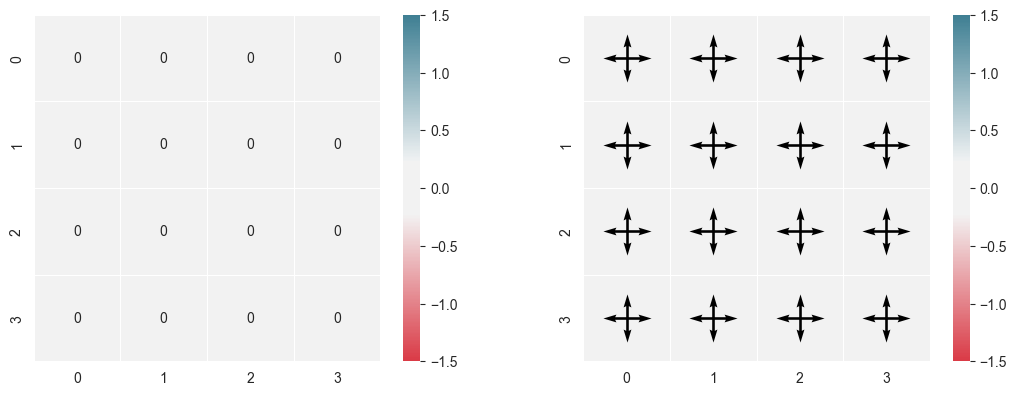

In [5]:
# Testing
Q = action_value_function(4, 4, 5)
plot_things(Q, game.get_action_set())

To see how the policy plot renders a greedy policy based on the Q-Values execute the cell bellow. Note that for simplicity, the value function plot sums the values of all actions per state. For that reason, seeing the relationship between the value function and policy plot may not be as straightforward as it was in the last notebook.

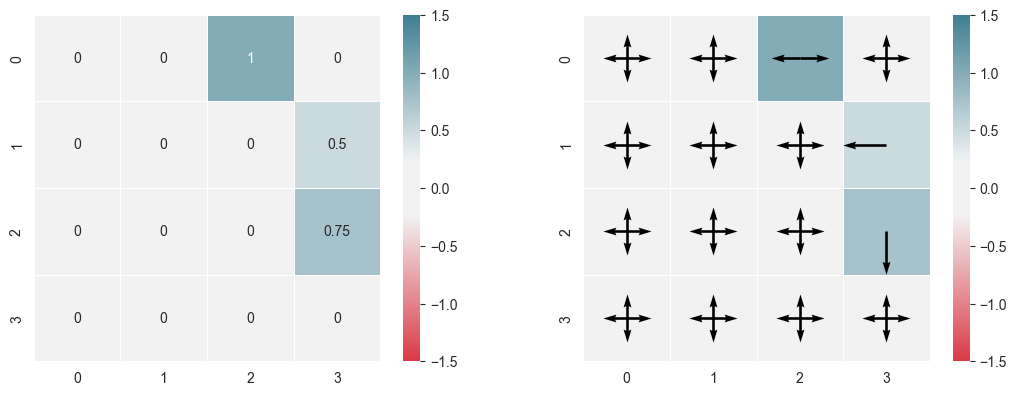

In [6]:
# set action LEFT (3) in state (0,2) to propability 1
Q[(0,2)][3] = 0.5
Q[(0,2)][2] = 0.5
Q[(1,3)][2] = 0.5
Q[(2,3)][1] = 0.75

plot_things(Q, game.get_action_set())

##### E-Greedy policy

Here you will implement an e-greedy action selection which is basically our e-greedy policy. There is no need to store the policy in a separate array anymore because we can choose the best actions based on the Q-values array directly. Note that the function should take explicit values for epsilon as its third argument. The decay of epsilon will be handeled separately in the loop. Make sure that if there are multiple equally good actions, the greedy part should select randomly between them!

Here are some functions you may find helpful for your implementation.

- `numpy.random.random`, `numpy.random.randint` etc.
- `numpy.random.choice` select a random value from an array 
- `numpy.where` will return a tuple of array(s), containing the indices of values that satisfy some condition. (In the case of a 1-D array, the tuple contains only 1 array for axis 0 etc.)

Example:
```python
x = np.array([1,2,3,1])
one_indices = np.where(x==1)[0] 
print(one_indices)
[0 3]
```

Here is what you have to implement:

$$\begin{eqnarray}
a = \begin{cases}
        \text{a random action}                             & \text{ with probability } \epsilon\\
        \\
        \arg \displaystyle \max_{a \in \mathcal{A}} Q(s,a) & \text{ with probability } 1-\epsilon
    \end{cases}
\end{eqnarray}$$

In [7]:
def choose_egreedy_action(Q, state, epsilon):
    # Chooses True with the probability of 1-epsilon
    if np.random.random() > epsilon:
        max_q_indices = np.where(Q[state] == np.max(Q[state]))
        return np.random.choice(max_q_indices[0])  # If True: return a random action from max q values
    
    return np.random.randint(len(Q[state]))  # Else: return random action regardless of q value

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

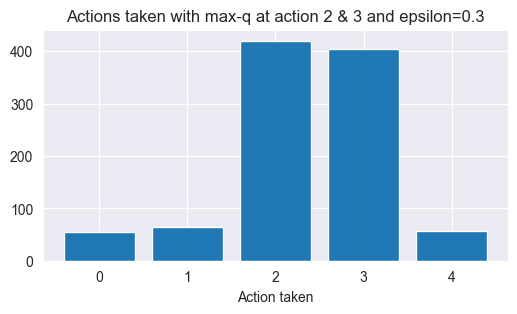

In [11]:
# Testing
chosen_actions = [choose_egreedy_action(Q, (0,2), 0.3) for _ in range(1000)]
counts = sorted(Counter(chosen_actions).items(), key=lambda x: x[0])

plt.figure(figsize=(6, 3))
plt.bar([x[0] for x in counts], [x[1] for x in counts])
plt.xlabel("Action taken")
plt.title("Actions taken with max-q at action 2 & 3 and epsilon=0.3")
plt.show()

<font color=blue><b>Comment:</b></font> To test the implemented `choose_egreedy_action` function, we run it 1000 times with a state that has a max q-value at actions 2 and 3. The epsilon was set at 0.3. We plot the distribution of the resulting chosen actions and can see, that the function works as intended. Most of the time, the function chose an action with the max q-value while sometimes (30%) it picked a random action.

##### Update

Finally you have to implement the update rule. The update should modify a specific Q-value in place and return nothing. Here again is the formula:

$$\begin{eqnarray} 
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a)}_{target} - \underbrace{Q(s_t, a_t)}_{current} \right] 
\end{eqnarray}$$

<font color=blue><h3>Function: Q-table Update</h3></font>
The following function was implemented to update the given Q-table according to the given parameters. It was implemented according to the formula provided above.

In [12]:
def update(Q, state, action, reward, next_state, gamma, alpha):
    current_q = Q[state][action] 
    max_next_q = max(Q[next_state])
    
    # Convert a reward of None to 0 to avoid type errors
    if reward == None: reward = 0
    
    # Calculate new Q value and replace it in the Q-table with the old value
    new_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
    Q[state][action] = new_q

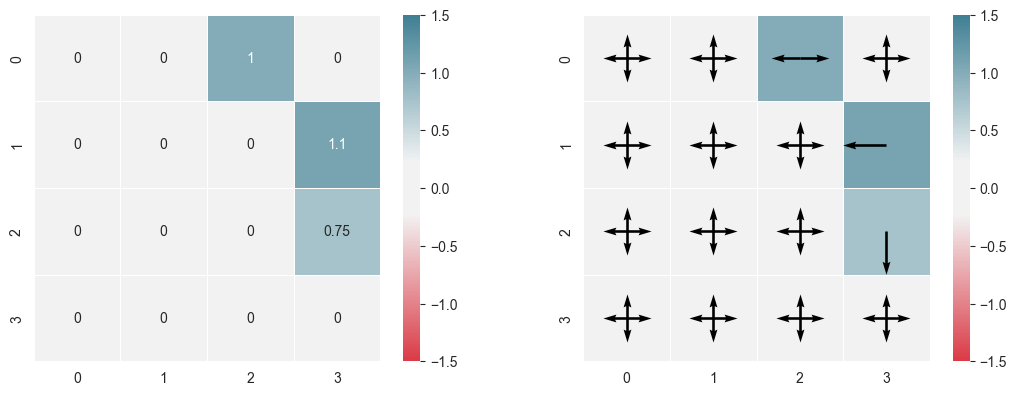

In [13]:
# Testing
update(Q, (1,3), action=2, reward=1, next_state=(2,3), gamma=0.9, alpha=0.5)
plot_things(Q, game.get_action_set())

### Build up from a basic agent-environment loop

Great, now we can start implementing the Q-learning agent. For a clean approach, we suggest that you build up from a basic agent-environment and add the missing parts one by one. You dont have to read everything at once, just **work through the steps one by one** and come back after you have finished a task. You may want to proceed like this:

1. Reimplement or copy & paste a **basic agent-environment loop**. This loop should contain a random agent that can play **multiple episodes** of the game and reports the total reward **per episode**.<br><br>

2. Initialize a fresh **Q-value function** and use it with the **e-greedy action selection** in the loop. Start by using a fixed `epsilon = 1`. Note that you will need the agents current state which you can get from `get_current_state`. The agent is still fully random at this point.<br><br>

3. Implement a **decay schedule** for epsilon. The decay should be controllable with a `final_epsilon` value and a `final_exploration_step` value. After this final step (or if epsilon becomes too small), epsilon should be fixed to this final value. An easy way to verify your implementation is to keep track of epsilon with a list and plot it afterwards. Even though we deacy epsilon now, the agent is still fully random since we don't improve the policy yet.
```
# While in the loop do something like: epsilon_schedule.append(epsilon)
# After the training plot the schedule: plt.plot(epsilon_schedule), plt.show()
```

4. If everything is working so far, integrate the **Q-learning update** into the loop. The full Q-learning algorithm is given in a cell below. If you are unsure, use it to check when to do what inside the loop. Congratulations, after this point you have implemented your first (Q-learning) agent that is actually able to **learn** something! Next, you definetly want to gain some insight of what is really going on. Either you want to debug your code or you want to verify the results in a more scientific way. In any case, back and forth between task 4 and 5 as you need to.<br><br>

5. Verify what the agent is doing. You have several options ranging from visual feedback to more scientific approaches which you would use in a paper or thesis. Include at least some of them into your loop.
    - **Visual feedback**: e.g. use `ui.render` and `time.sleep`.<br><br>
    - **Live plot of Q and Pi**: e.g. use `plot_things` , `plt.pause` and `display.clear_output(wait=True)`.<br><br>
    - **Data visualisation**: e.g. keep track of `episode_rewards`, `epsilon_schedule` etc. and plot them afterwards.

    Note that the *live* plotting option can be very *slow*. If you run the agent for many episodes this will take some time. For that reason you may prefer to plot the value function and policy only every `n` steps or just after the training. If you still want to plot the Q-learning agent *live* and in action (which is cool to watch) you may prefer to replace the `%matplotlib inline` backend with a more performant backend like `osx, qt, gtk,` etc. For a list of backends execute `%matplotlib -l` on top of a cell. **NOTE: If you change the plotting backend, better restart the notebook.** Do not switch backends from cell to cell. This kind of works but may result in significant slow downs.

In [14]:
import time
import copy

<font color=blue><h3>Function: Performance Plotting</h3></font>
We created the function `plot_train_perf` to visualize important datapoints during and after Q-learning training. It consists of four line plots that display the total steps needed per epoch to reach the finish, the total reward the agent gained at the end of an epoch, the magnitude of changes in the Q table compared to the epoch before, and the epsilon decay. We mainly use this function in our main training function `q_training` described below. <br>
The function can take an optional value for a stopping condition value. If provided, the stopping condition is visualized alongside the total changes in the Q table as a dotted line and the y axis is limited for better viewability.

In [15]:
def plot_train_perf(steps_per_epoch, reward_per_epoch, total_Q_diff, epsilon_decay, stopping_val=None):
    fig = plt.figure(figsize=(13,6))
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(f"Training Performance after {len(steps_per_epoch)} Epochs", fontsize=15)
    
    fig.add_subplot(2, 2, 1)
    plt.plot(steps_per_epoch, "b")
    plt.title("Total Steps to reach the Finish", fontsize=13)
    plt.ylabel("Total Steps")
    
    fig.add_subplot(2, 2, 2)
    plt.plot(reward_per_epoch, "g")
    plt.title("Total Reward gained per Epoch", fontsize=13)
    plt.ylabel("Total Reward")
    
    fig.add_subplot(2, 2, 3)
    plt.plot(total_Q_diff, "r")
    if stopping_val is not None:
        plt.axhline(y=stopping_val, color="black", linestyle="--")
        plt.ylim((0, stopping_val*10))
    plt.title("Total Q Change", fontsize=13)
    plt.xlabel("Epoch")
    plt.ylabel("Total Change")
    
    fig.add_subplot(2, 2, 4)
    plt.plot(epsilon_decay, "y")
    plt.title("Epsilon Decay", fontsize=13)
    plt.xlabel("Epoch")
    plt.ylabel("Epsilon")
    
    plt.show()

<font color=blue><h3>Function: Main Training</h3></font>
We created a main training function `q_training` that includes a complete Q-Learning training run with configurable parameters:
* `level` = The gridworlds level chosen for training. Affects the size of the Q-table and the simulation that gets run.
* `epochs` = The number of training epochs. In our case, one game equals one epoch.
* `epsilon_type` = Describes the type of epsilon decay that should happen during training. We implemented three types: **linear**, **exponential**, and **first**. The different types will be described in more detail later in the notebook.
* `gamma` = Gamma value used in the update function defined above
* `alpha` = Alpha value used in the update function defined above
* `max_steps_per_epoch` = Defines the maximum amount of steps the agent has in the simulation to reach the finish. The epoch will stop if the maximum value is reached during a game. This prevents the agent getting potentially stuck.
* `plot_frequency` = Determines how often the plots are drawn during training. Drawing plots frequently in long training sessions can slow down training significantly.
* `stopping_condition` = The stopping condition can be defined optinally. It determines an early stop in the training. If the summed Q-table updates between epochs are lower than the stopping condition in the last 10 epochs, the training is stopped early. This will be used later in the notebook to compare different hyperparameters. <br><br>

The function returns the resulting trained Q-table and a dictionary with relevant data gathered during training. This includes the number of steps per epoch, the total rewards per epoch, the summed changes of the Q-table and the epsilon decay.

In [16]:
def q_training(level, epochs, epsilon_type, gamma=0.9, alpha=0.5, visualize=True,
               max_steps_per_epoch=1000, plot_frequency=100, stopping_condition=0):
    
    # Initiate dummy game to get the game world dimensions for the q table
    dummy_game = exitgames.make_game(level=level)
    world_x, world_y = dummy_game.get_world_map().shape[0]-2, dummy_game.get_world_map().shape[1]-2
    
    # Initiate new Q table
    Q = action_value_function(world_x, world_y, num_actions=len(dummy_game.get_action_set()))

    # Performance measures for plotting
    steps_per_epoch, reward_per_epoch = [], []
    total_Q_diff, epsilon_decay = [1], []

    # Train for i epochs
    for i in range(epochs):
        # Calculate epsilon based on given type
        if epsilon_type == "linear": epsilon = 1-1/epochs*i
        elif epsilon_type == "exponential": epsilon = -0.05**(1/((i+1)/(epochs/100)))+1
        elif epsilon_type == "first": epsilon = 1 if i < epochs/2 else 0.05
        else:  # Stop training if unknown epsilon type was given
            print("Unknown epsilon type")
            return

        # Initiate new game
        game, ui = exitgames.make_game(level=level), exitgames.get_notebook_ui()
        obs, _, _ = game.its_showtime()
        total_reward, total_steps = 0, 0  # Performance measures for plotting
        old_Q = copy.deepcopy(Q)
        
        # Run game till finish is reached
        while not game.game_over:
            current_state = get_current_state(obs)
            action = choose_egreedy_action(Q, current_state, epsilon)
            obs, reward, _ = game.play(action)
            next_state = get_current_state(obs)
            update(Q, current_state, action, reward, next_state, gamma, alpha)
            
            # Update performance measure vals (for plots)
            total_reward += reward if reward is not None else 0
            total_steps += 1
            
            # Stop game if max steps is reached
            if total_steps >= max_steps_per_epoch:
                break
        
        # Update performance measure lists (for plots)
        steps_per_epoch.append(total_steps)
        reward_per_epoch.append(total_reward)
        epsilon_decay.append(epsilon)
        
        # Plot performance during training according to defined frequency
        if i%plot_frequency == 0 and i != 0 and visualize:
            plot_train_perf(steps_per_epoch, reward_per_epoch, total_Q_diff, epsilon_decay, 
                            stopping_val=stopping_condition if stopping_condition != 0 else None)
            display.clear_output(wait=True)
              
        # Evaluate if stopping condition is met
        total_Q_diff.append(np.sum(np.absolute(old_Q-Q)))
        if len(total_Q_diff) > 10:
            if np.max(total_Q_diff[-10:]) <= stopping_condition:
                print("Stopping training because stopping condition was met in epoch", i)
                break   
        
    # final plots
    if visualize:
        plot_train_perf(steps_per_epoch, reward_per_epoch, total_Q_diff, epsilon_decay, 
                       stopping_val=stopping_condition if stopping_condition != 0 else None)    
        plot_things(Q, game.get_action_set())
    
    # Return Q table and a dictionary with all relevant training data for later comparison
    train_data = {"steps": steps_per_epoch, "reward": reward_per_epoch, "q_diff": total_Q_diff, "epsilon": epsilon_decay}
    return Q, train_data

<font color="blue"><b>Comment:</b></font> For our initial training, we decided to use level 1 instead of level 0, because we thought the level structure of level 0 was too simple for a meaningfull analysis. <br>
We expect that the optimal path will be found during training. Because level 1 takes many steps to reach the finish, we set a high gamma value of 0.9. The stopping condition was set at 0.1, altough we dont expect it to be reached in the 300 epochs that were set. We assume that the complexity of the level requires more epochs for the action value function to converge.

Stopping training because stopping condition was met in epoch 209


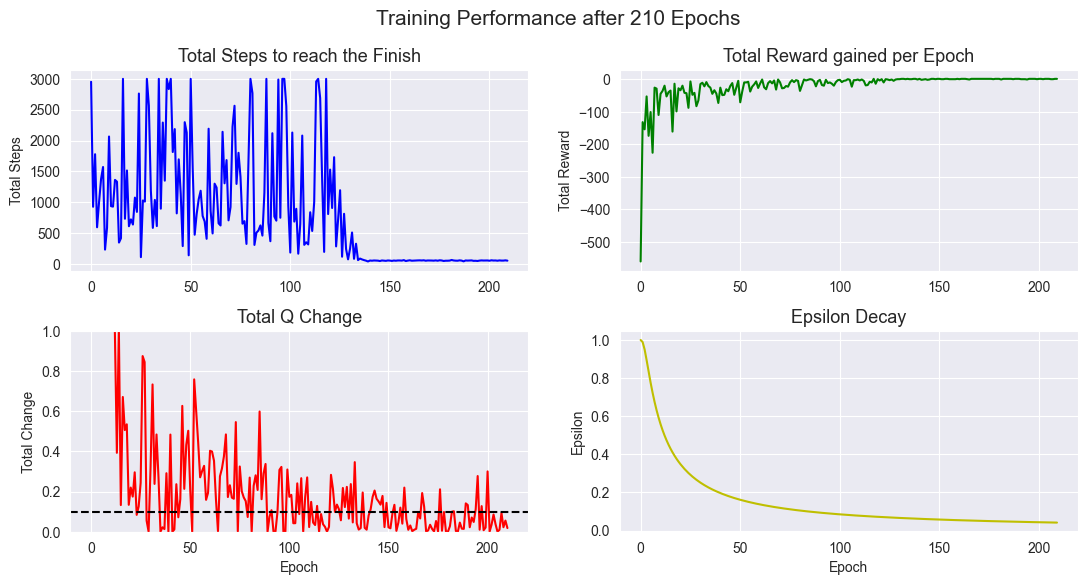

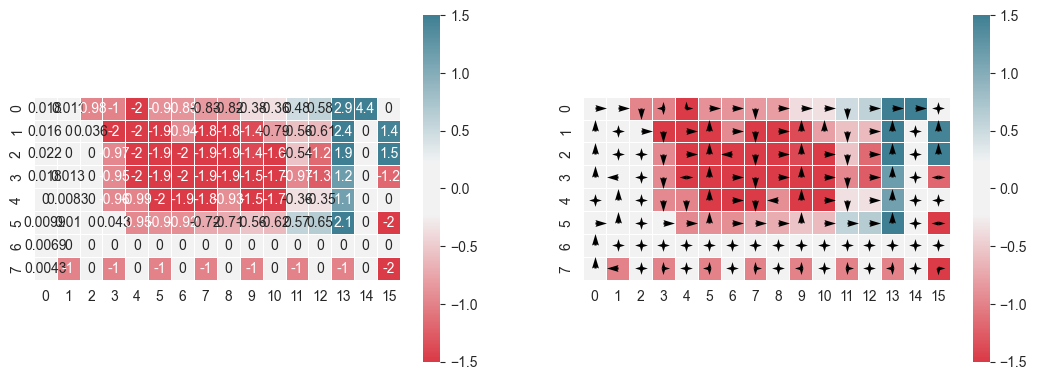

In [132]:
trained_Q, data_exponential = q_training(level=1, epochs=300, epsilon_type="exponential", gamma=0.9, 
                              alpha=0.5, max_steps_per_epoch=3000, plot_frequency=20, 
                              stopping_condition=0.1)

<font color="blue"><h4>Results Analysis</h4></font>
The final plots of the training run show a successfull training. We can see that the agent initially took many steps to reach the finish (upper left plot). The step count was often in the thousands and reached the `max_steps_per_epoch` value several times, which was set at 3000. After about 120 epochs, the taken steps to reach the finish sunk rapidly and converged at a value of 54. <br>
The reward in the beginning of the training (upper right plot) had a large negative value, indicating that the agent ran over many traps recieving a reward of -1 each time. After about 120 epochs the agent figured out to consistently avoid the traps and accieved a total reward of 1 most of the times. <br>
In both upper plots, we can see the occational fluctuation after both values converged. We assume this is because the epsilon value has not reached zero, which resulted in occational random actions forcing the agent to take a "wrong" step. <br>
Unlike we expected, the stopping condition was reached in the course of training after 210 epochs. This can also be seen in the lower left plot where the total change in the Q table was below a value of 0.1 for 10 consecutive epochs thus triggering the early stop. In this regard, we were wrong in assuming the agent would take considerably longer to learn level 1. We can also verify that the level was solved successfully by looking at the Q-table representation in the last plot the function outputs. We can see the optimal path in the arrows pointing around the traps and ending at the finish tile. <br>

Testing the trained action value function by "playing" the level was moved to the further ideas section because of the further ideas task to develop a play function.

<font color=blue><h3>Epsilon function showcase</h3></font>
The following plot shows the different epsilon functions that we implemented in our training function. We desided to plot these to be able to better compare their decay rates.

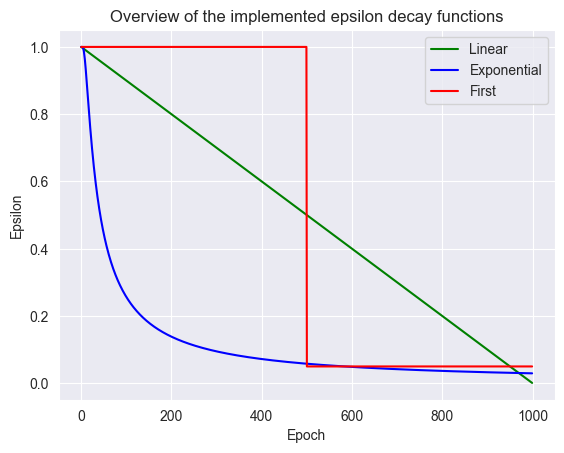

In [19]:
linear, exponential, first = [], [], []
epochs = 1000

for i in range(epochs):
    linear.append(1-1/epochs*i)
    exponential.append(-0.05**(1/((i+1)/(epochs/100)))+1)
    first.append(1 if i < epochs/2 else 0.05)
               
plt.plot(linear, "g", label="Linear")
plt.plot(exponential, "b", label="Exponential")
plt.plot(first, "r", label="First")
plt.title("Overview of the implemented epsilon decay functions")
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

<font color="blue"><b>Comment:</b></font> To be able compare the different epsilon decay functions, we will run the same training as before for the linear and first method as well. The results can be seen below. <br>
**Note:** A more in depth analysis of hyperparameter performance including epsilon decay will be done in the further ideas section of the notebook.

Stopping training because stopping condition was met in epoch 106


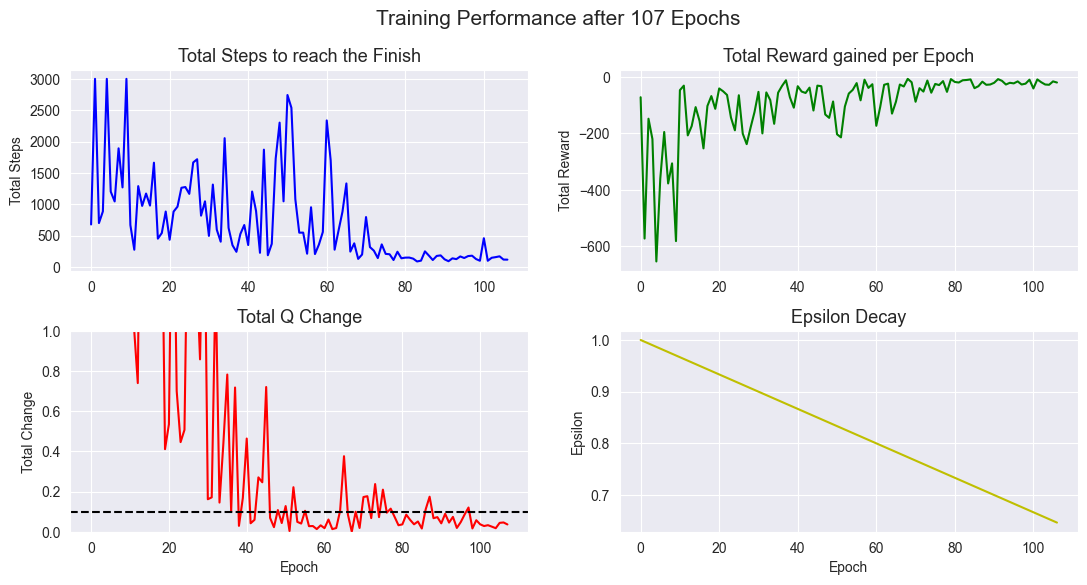

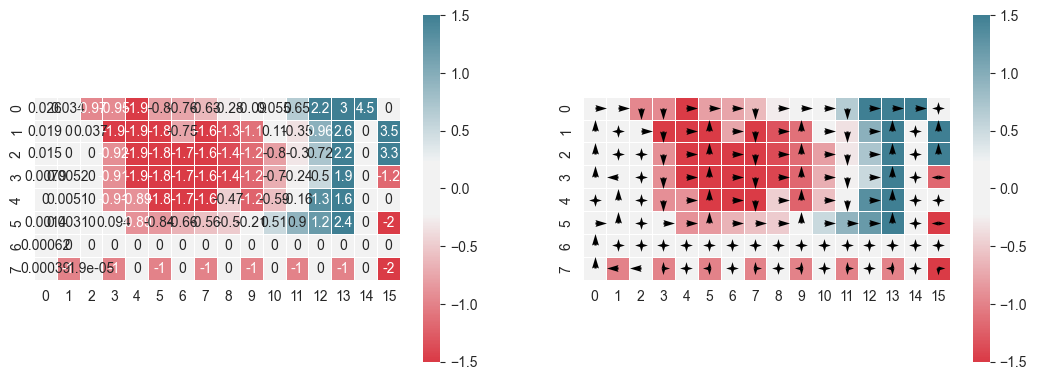

In [133]:
trained_Q_linear, data_linear = q_training(level=1, epochs=300, epsilon_type="linear", gamma=0.9, 
                                           alpha=0.5, max_steps_per_epoch=3000, plot_frequency=20, 
                                           stopping_condition=0.1)

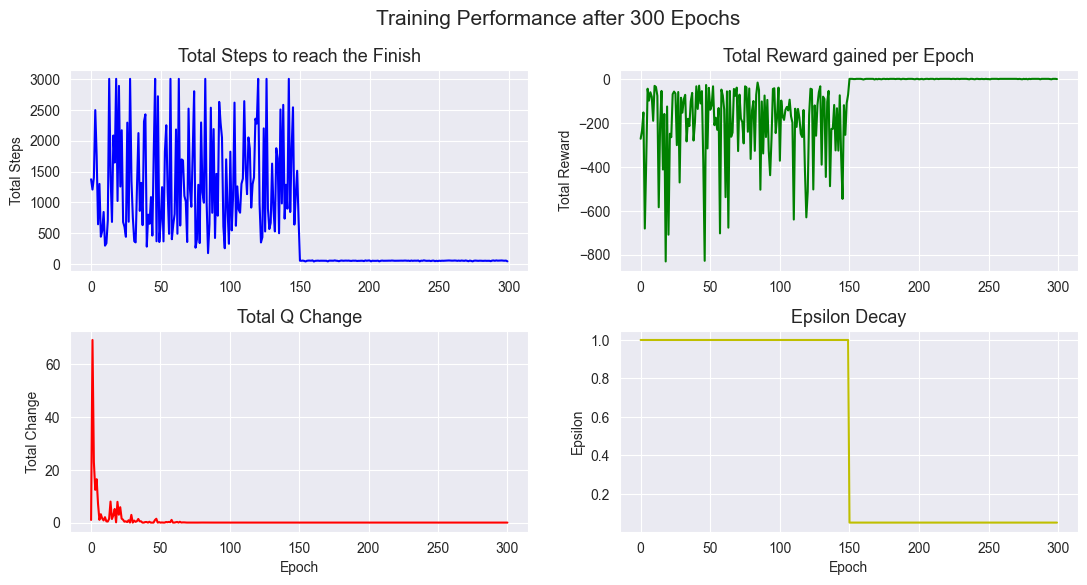

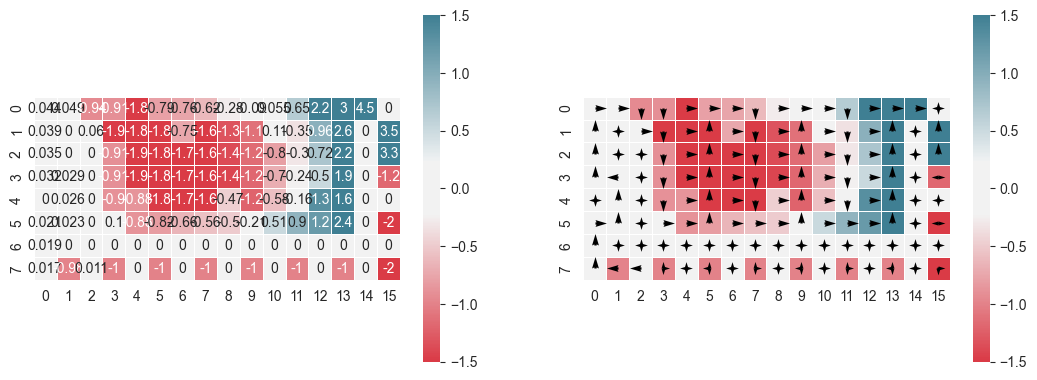

In [135]:
trained_Q_first, data_first = q_training(level=1, epochs=300, epsilon_type="first", gamma=0.9, 
                                         alpha=0.5, max_steps_per_epoch=3000, plot_frequency=20, 
                                         stopping_condition=0)

<font color="blue"><b>Comment:</b></font> Looking at the results we can see that linear and "first" epsilon decay also resulted in the optimal strategy being found and the q-table converging. With this initial test, all decay methods seem equally viable for this task, as the performance is similar across (This is not our final verdict. There will be an indept analysis in the further ideas section with a different conclusion). 

---
### Q-learning (off-policy TD control) for estimating $\pi \approx \pi∗$

Algorithm parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$ <br>
Initialize $Q(s, a)$, for all $s \in S^+$, $a \in A(s)$, arbitrarily except that $Q(terminal , ·) = 0$

Loop for each episode: 
- Initialize $S$ <br>
- Loop for each step of episode: <br>
    - Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br>
    - Take action $A$, observe $R, S′$<br>
    - $Q(S, A) \gets Q(S, A) + \alpha \Big[R + γ max_a Q(S′, a) − Q(S, A)\Big]$ 
    - $S \gets S′$
- until $S$ is terminal
---

## Further Ideas

- experiment with different exploration settings! 
- compare the performance of your agent against a random agent.
- implement a "play" only loop/method that can take the learned value function.

(only if good in time, if not, better start with the next notebook)

- experiment with different hyperparameters and compare your results in a proper data visualisation.
- read and/or reason about potentiall shortcomings/improvements/efficiency etc. and write down your thoughts.
- experiment with exitgames level 1.

## Next: PIA - Reinforcement Learning: 4. Deep Reinforcement Learning (DQN)

<font color=blue><h3>Function: Play Level</h3></font>
We implemented a function that can take a trained Q-table and plays a greedy game on the selected level. The parameters are:
* `Q` = The Q-Table. Should be trained beforehand
* `level` = The selected level for gridworlds
* `visualize` = Determines if the game board is displayed during the run. This can be turned off if only the results are necessary for comparisons
* `max_steps` = The maximum amounts of steps the agent can take. Prevents stuck agents that keep the game running forever. <br><br>

The function returns the total state the agent took to reach the finish and the total reward it recieved during the run.

In [40]:
def play_level(Q, level, visualize=True, max_steps=100):
    # Run game with epsilon = 0 (full greedy)
    game, ui = exitgames.make_game(level=level), exitgames.get_notebook_ui()
    obs, _, _ = game.its_showtime()
    total_reward, total_steps = 0, 0
    
    # Run game. 
    while not game.game_over and total_steps < max_steps:
        action = choose_egreedy_action(Q, get_current_state(obs), epsilon=0)
        obs, reward, _ = game.play(action)
        total_reward += reward if reward is not None else 0
        total_steps += 1   
        
        if visualize:
            print(f"Current step: {total_steps}. Total reward: {total_reward}")
            ui.render(obs.board, "COLOR")
            time.sleep(0.2)
    
    return total_steps, total_reward

In [41]:
_, _ = play_level(trained_Q, level=1)

Current step: 54. Total reward: 1


In [42]:
print(play_level(trained_Q, level=1, visualize=False))

(54, 1)


<font color="blue"><b>Comment:</b></font> After testing the function with the initially trained action-value function (Q-table) we can see that the agent can solve the level in an optimal way. He takes 54 steps while avoiding all traps resulting in a total reward of 1. We also tested not visualizing the run as we want to use this in later parts of the notebook to compare performance between agents. This also worked well and delivered the results instantly

<font color=blue><h3>Comparing against a random agent</h3></font>
To compare a trained agent with a random agent, we trained 3 agents on the 3 levels. This can be seen below. We used a `linear epsilon decay` and an `alpha` value of 0.5. For the last level, we had to increase the `gamma` value from 0.9 to 0.95 to limit the long term reward fall off. We also increased the maximum steps allowed per epoch because we discovered that the agent needed more time to explore the level due to its size. To keep the output readable, only the last training of level 2 was visualized. We can see that the training went successfull as the stopping condition was reached in epoch 1160. That means that the Q-Table converged. <br>

In this experiment we expect a huge difference in performance between the trained and random agents. Especially in the levels 1 and 2, which are much bigger with more difficult paths.

Stopping training because stopping condition was met in epoch 1160


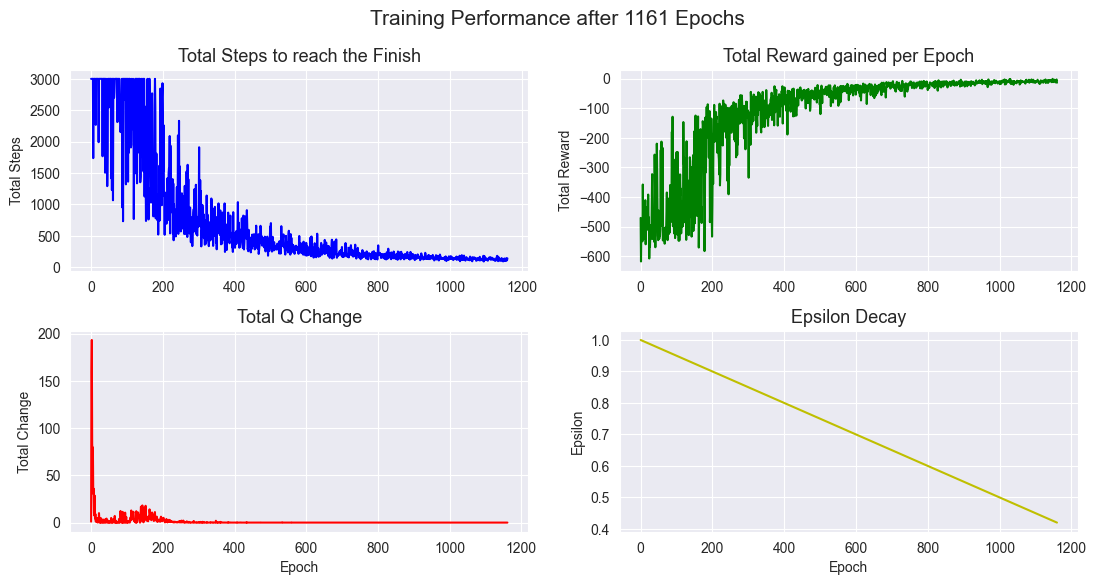

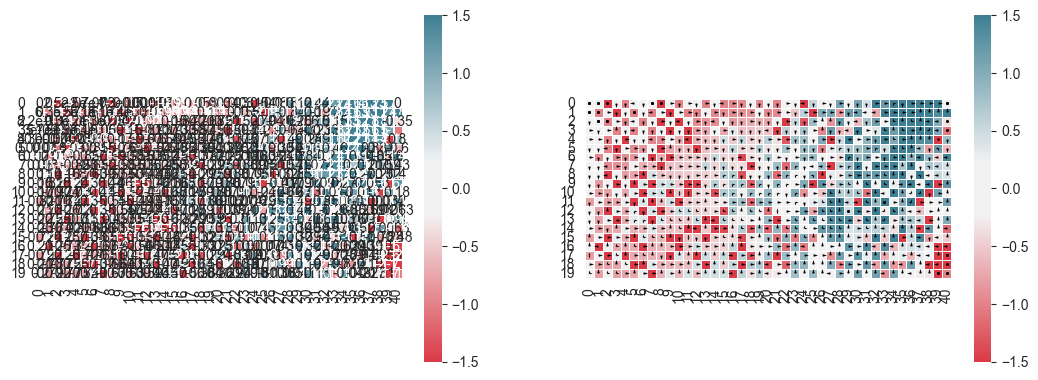

In [33]:
# Training agents with q-learning on all 3 levels
lvl0_Q, _ = q_training(level=0, epochs=200, epsilon_type="linear", gamma=0.9, alpha=0.5, 
                       max_steps_per_epoch=1000, plot_frequency=999, visualize=False)
lvl1_Q, _ = q_training(level=1, epochs=400, epsilon_type="linear", gamma=0.9, alpha=0.5, 
                       max_steps_per_epoch=1000, plot_frequency=999, visualize=False)
lvl2_Q, _ = q_training(level=2, epochs=2000, epsilon_type="linear", gamma=0.95, alpha=0.5, 
                       max_steps_per_epoch=3000, plot_frequency=9999, visualize=True)

<font color="blue"><b>Comment:</b></font> 
To create a random agent, we initialized a new action value function for each level. As all values in those Q-table were 0, the greedy function will always choose randomly.

In [35]:
# Creating random agents by using an empty Q-table
lvl0_random = action_value_function(4, 4, num_actions=len(dummy_game.get_action_set()))
lvl1_random = action_value_function(8, 16, num_actions=len(dummy_game.get_action_set()))
lvl2_random = action_value_function(20, 41, num_actions=len(dummy_game.get_action_set()))

<font color="blue"><b>Comment:</b></font> Next, we ran simulation for all 6 agents with the implemented function `play_level`. To limit randomness, we ran the simualtion for every agent 50 times and averaged the results. As a performance measure we used the outputs of our play function which are the total steps taken and the total reward earned

In [48]:
all_agents = [[0, lvl0_random], [1, lvl1_random], [2, lvl2_random], [0, lvl0_Q], [1, lvl1_Q], [2, lvl2_Q]]
results_steps = [[], [], [], [], [], []]
results_rewards = [[], [], [], [], [], []]
              
for _ in range(50):
    i=0
    for lvl, agent in all_agents:
        steps, reward = play_level(agent, level=lvl, visualize=False, max_steps=5000)
        results_steps[i].append(steps)
        results_rewards[i].append(reward)
        i+=1
        
steps_mean = [np.mean(i) for i in results_steps]
rewards_mean = [np.mean(i) for i in results_rewards]

In [63]:
print(f"Level 0 -  Random: mean-steps={steps_mean[0]}, mean-reward={rewards_mean[0]}")
print(f"Level 0 - Trained: mean-steps={steps_mean[3]}, mean-reward={rewards_mean[3]}")
print(f"Level 1 -  Random: mean-steps={steps_mean[1]}, mean-reward={rewards_mean[1]}")
print(f"Level 1 - Trained: mean-steps={steps_mean[4]}, mean-reward={rewards_mean[4]}")
print(f"Level 2 -  Random: mean-steps={steps_mean[2]}, mean-reward={rewards_mean[2]}")
print(f"Level 2 - Trained: mean-steps={steps_mean[5]}, mean-reward={rewards_mean[5]}")

Level 0 -  Random: mean-steps=81.3, mean-reward=-6.86
Level 0 - Trained: mean-steps=6.0, mean-reward=1.0
Level 1 -  Random: mean-steps=1431.68, mean-reward=-231.68
Level 1 - Trained: mean-steps=54.0, mean-reward=1.0
Level 2 -  Random: mean-steps=3971.82, mean-reward=-716.08
Level 2 - Trained: mean-steps=63.0, mean-reward=1.0


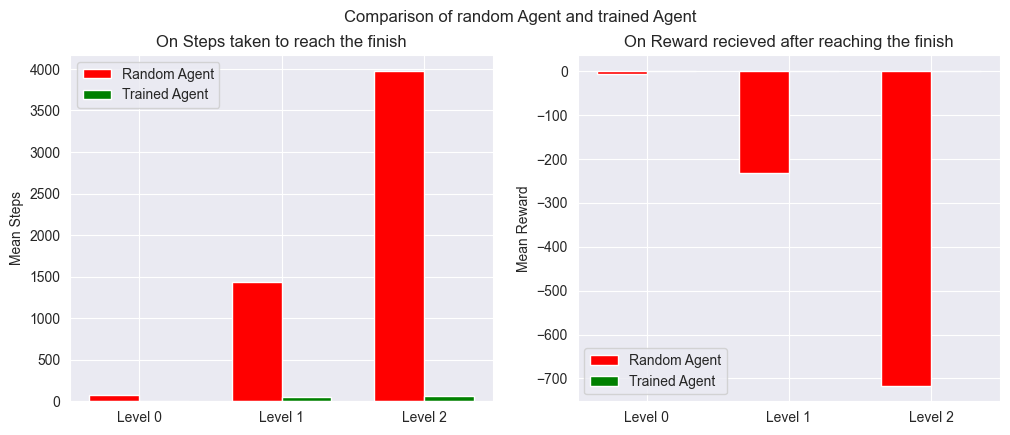

In [61]:
# Plotting the performance comparison for steps
x = ["Level 0", "Level 1", "Level 2"]

ind = np.arange(len(x))
width = 0.35 # bar width
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
fig.suptitle("Comparison of random Agent and trained Agent")

ax1.bar(ind - 0.35/2, steps_mean[:3], width, label="Random Agent", color="red")
ax1.bar(ind + 0.35/2, steps_mean[3:], width, label="Trained Agent", color="green")
ax1.set_ylabel("Mean Steps")
ax1.set_title("On Steps taken to reach the finish")
ax1.set_xticks(ind)
ax1.set_xticklabels(x)
ax1.legend()

ax2.bar(ind - 0.35/2, rewards_mean[:3], width, label="Random Agent", color="red")
ax2.bar(ind + 0.35/2, rewards_mean[3:], width, label="Trained Agent", color="green")
ax2.set_ylabel("Mean Reward")
ax2.set_title("On Reward recieved after reaching the finish")
ax2.set_xticks(ind)
ax2.set_xticklabels(x)
ax2.legend()

plt.show()

<font color="blue"><b>Comment:</b></font> The results of the experiment can be seen in the plot above, as expected, the trained agents performed significatly better than the random agents. Especially in the higher levels, the random agents walked around the board for several thousand steps on average before finding the exit. In comparison, the trained agents were able to consitently find the best route. In hindsight, we realized that we did not have to run the trained agents several times as they will always act greedy on the trained actiob value function and therefore take the same path. <br>
Because of the big difference in the agents, the performance of the trained agents is barely visible in the plot. Because of this we plotted the same results again with limited y-axis. This can be seen in the plot below. Here we can see batter that the trained agents all accieved a reward of 1 in every level, in contrast, the random agents, as expected, walked over many traps and had a large negative reward in the end.

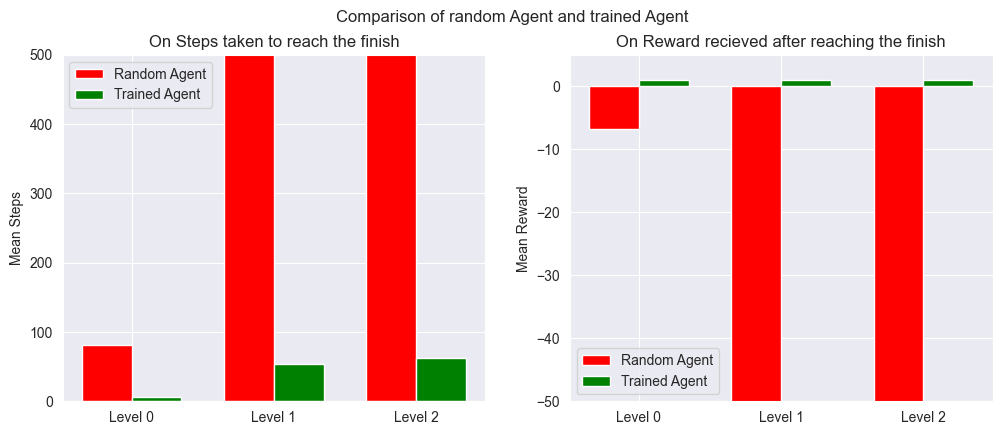

In [59]:
ind = np.arange(len(x))
width = 0.35 # bar width
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
fig.suptitle("Comparison of random Agent and trained Agent")

ax1.bar(ind - 0.35/2, steps_mean[:3], width, label="Random Agent", color="red")
ax1.bar(ind + 0.35/2, steps_mean[3:], width, label="Trained Agent", color="green")
ax1.set_ylabel("Mean Steps")
ax1.set_title("On Steps taken to reach the finish")
ax1.set_xticks(ind)
ax1.set_ylim((0, 500))
ax1.set_xticklabels(x)
ax1.legend()

ax2.bar(ind - 0.35/2, rewards_mean[:3], width, label="Random Agent", color="red")
ax2.bar(ind + 0.35/2, rewards_mean[3:], width, label="Trained Agent", color="green")
ax2.set_ylabel("Mean Reward")
ax2.set_title("On Reward recieved after reaching the finish")
ax2.set_xticks(ind)
ax2.set_ylim((-50, 5))
ax2.set_xticklabels(x)
ax2.legend()

plt.show()

<font color=blue><h3>Hyperparameter Testing</h3></font>
In the following experiment, we used a grid search approach to compare the impact on performance of different hyperparameter combinations.  <br>

We needed to decide how to approch measuring the performance. In pre-testing we found that in general all models will eventually converge and find the optimal route (Excluding irrational choices like setting the gamma to zero). This means we need to measure performance based on the time it takes the training to reach this optimal state. We first wanted to use the early stopping condition we implemented into the training function to determine how fast the agent was able to learn the level. However upon further consideration, we decided against using the early stopping condition for determining the number of episodes the configuration takes to train, because the epsilon decay functions scale differently depending on the total number of epochs defined. This would result in a bias. For example, with linear epsilon decay, the early stopping condition would likely never be met because epsilon is only nearing zero at the end of training, while in exponential decay that would happen much sooner. <br>

Because of this we tested based on different total training epochs and compared the performance of reward and step count. In other words, if one hyperparameter combination was able to figure out the solution in a 100 epoch training session while the other needed a session of 200, it would be better. <br>

The different hyperparameters tested were gamma, alpha, and epsilon decay. Below, the implemented grid search approach can be seen. We use the built in library `itertools` to get all possible combinations of our parameters. <br>

For this experiment, we expect exponential decay to perform the best as we think it is most logical to first pick random actions but then quickly use the information gathered to go further in the maze more quickly than other methods and find the finish sooner.

In [65]:
import itertools

In [66]:
gamma_opts = [0.5, 0.7, 0.9]
alpha_opts = [0.25, 0.5, 0.75]
epsilon_opts = ["linear", "exponential", "first"]
epochs = [50, 100, 150, 200, 250, 300, 350, 400]

all_params = [gamma_opts, alpha_opts, epsilon_opts, epochs]

results = []

print(f"Now starting grid search with {len(list(itertools.product(*all_params)))} training runs")
start_time = time.time()
i = 1

for gamma, alpha, epsilon, epoch in itertools.product(*all_params):
    run_time = time.time()
    
    # Run training with selected parameters
    new_Q, train_data = q_training(level=1, epochs=epoch, epsilon_type=epsilon, gamma=gamma, 
                                   alpha=alpha, max_steps_per_epoch=1000, plot_frequency=999,
                                   visualize=False)
    
    # Run test to determine performance
    total_steps, total_reward = play_level(new_Q, level=1, visualize=False, max_steps=500)
    
    # Add results to result list
    results.append({"gamma":gamma, "alpha":alpha, "epsilon":epsilon, "epochs":epoch,
                    "total_steps":total_steps, "total_reward":total_reward, 
                    "train_data":train_data})
    
    # print(f"Training {i} finished after {round(time.time()-run_time)} seconds")
    i += 1

print(f"Grid search finished after {round((time.time()-start_time)/60)} minutes.")

Now starting grid search with 216 training runs
Stopping training because stopping condition was met in epoch 203
Stopping training because stopping condition was met in epoch 392
Stopping training because stopping condition was met in epoch 134
Stopping training because stopping condition was met in epoch 162
Grid search finished after 32 minutes.


<font color="blue"><b>Comment:</b></font> All results of the grid search were saved in the `results` array. To be able to display it properly, the data was transformed in the following code cells.

In [106]:
filtered_list = [[i["total_steps"], i["total_reward"], i["epochs"], i["gamma"], i["alpha"], i["epsilon"]] for i in results]

# Printing the first 8 examples to verify
for j in filtered_list[:8]:
    print(j)

[500, 0, 50, 0.5, 0.25, 'linear']
[500, 0, 100, 0.5, 0.25, 'linear']
[500, 0, 150, 0.5, 0.25, 'linear']
[500, 0, 200, 0.5, 0.25, 'linear']
[307, 1, 250, 0.5, 0.25, 'linear']
[54, 1, 300, 0.5, 0.25, 'linear']
[54, 1, 350, 0.5, 0.25, 'linear']
[54, 1, 400, 0.5, 0.25, 'linear']


In [107]:
comp_steps_dict = {}
comp_reward_dict = {}

for entry in filtered_list:
    key = (entry[-3], entry[-2], entry[-1])
    if key in comp_steps_dict:
        # We dont need to sort by epochs, because it was already sorted in the creation of the data
        comp_steps_dict[key].append(entry[0])
        comp_reward_dict[key].append(entry[1])
    else:
        comp_steps_dict[key] = [entry[0]]
        comp_reward_dict[key] = [entry[1]]

In [110]:
# Converting to array readable by matplotlib table

steps_plt_array = []
for key, val in comp_steps_dict.items():
    steps_plt_array.append([key[2], key[0], key[1]] + [i for i in val])
    
rewards_plt_array = []
for key, val in comp_reward_dict.items():
    rewards_plt_array.append([key[2], key[0], key[1]] + [i for i in val])

# Sort both arrays according to epsilon
steps_plt_array.sort()
rewards_plt_array.sort()

In [115]:
# Printing the first 12 examples to verify
steps_plt_array[:12]

[['exponential', 0.5, 0.25, 500, 500, 500, 500, 54, 54, 54, 54],
 ['exponential', 0.5, 0.5, 500, 500, 500, 217, 54, 54, 500, 54],
 ['exponential', 0.5, 0.75, 500, 500, 500, 500, 54, 54, 54, 54],
 ['exponential', 0.7, 0.25, 500, 500, 500, 165, 201, 54, 54, 54],
 ['exponential', 0.7, 0.5, 500, 500, 500, 500, 54, 54, 54, 54],
 ['exponential', 0.7, 0.75, 500, 500, 500, 500, 500, 54, 54, 54],
 ['exponential', 0.9, 0.25, 500, 500, 500, 500, 54, 54, 54, 54],
 ['exponential', 0.9, 0.5, 500, 500, 249, 67, 54, 54, 54, 54],
 ['exponential', 0.9, 0.75, 500, 500, 500, 500, 75, 54, 54, 54],
 ['first', 0.5, 0.25, 500, 437, 54, 54, 54, 54, 54, 54],
 ['first', 0.5, 0.5, 500, 54, 54, 54, 54, 54, 54, 54],
 ['first', 0.5, 0.75, 500, 500, 54, 54, 54, 54, 54, 54]]

<font color="blue"><b>Comment:</b></font> A Color palete was created to better show the difference in the upcoming comparison tables. The colors are based on performance in level 1

In [124]:
def color_palete(val, typ):
    if typ == "steps":
        palete = {54:"green", 100:"yellow", 200:"orange", 500:"red"}
    elif typ == "reward":
        palete = {-10:"red", -5:"orange", 0:"yellow", 1:"green"}
    
    for num in palete:
        if val <= num:
            return palete[num]

<font color="blue"><b>Comment:</b></font> Finally two tables representing the color coded results were created with matplotlib for the total steps and the total reward.

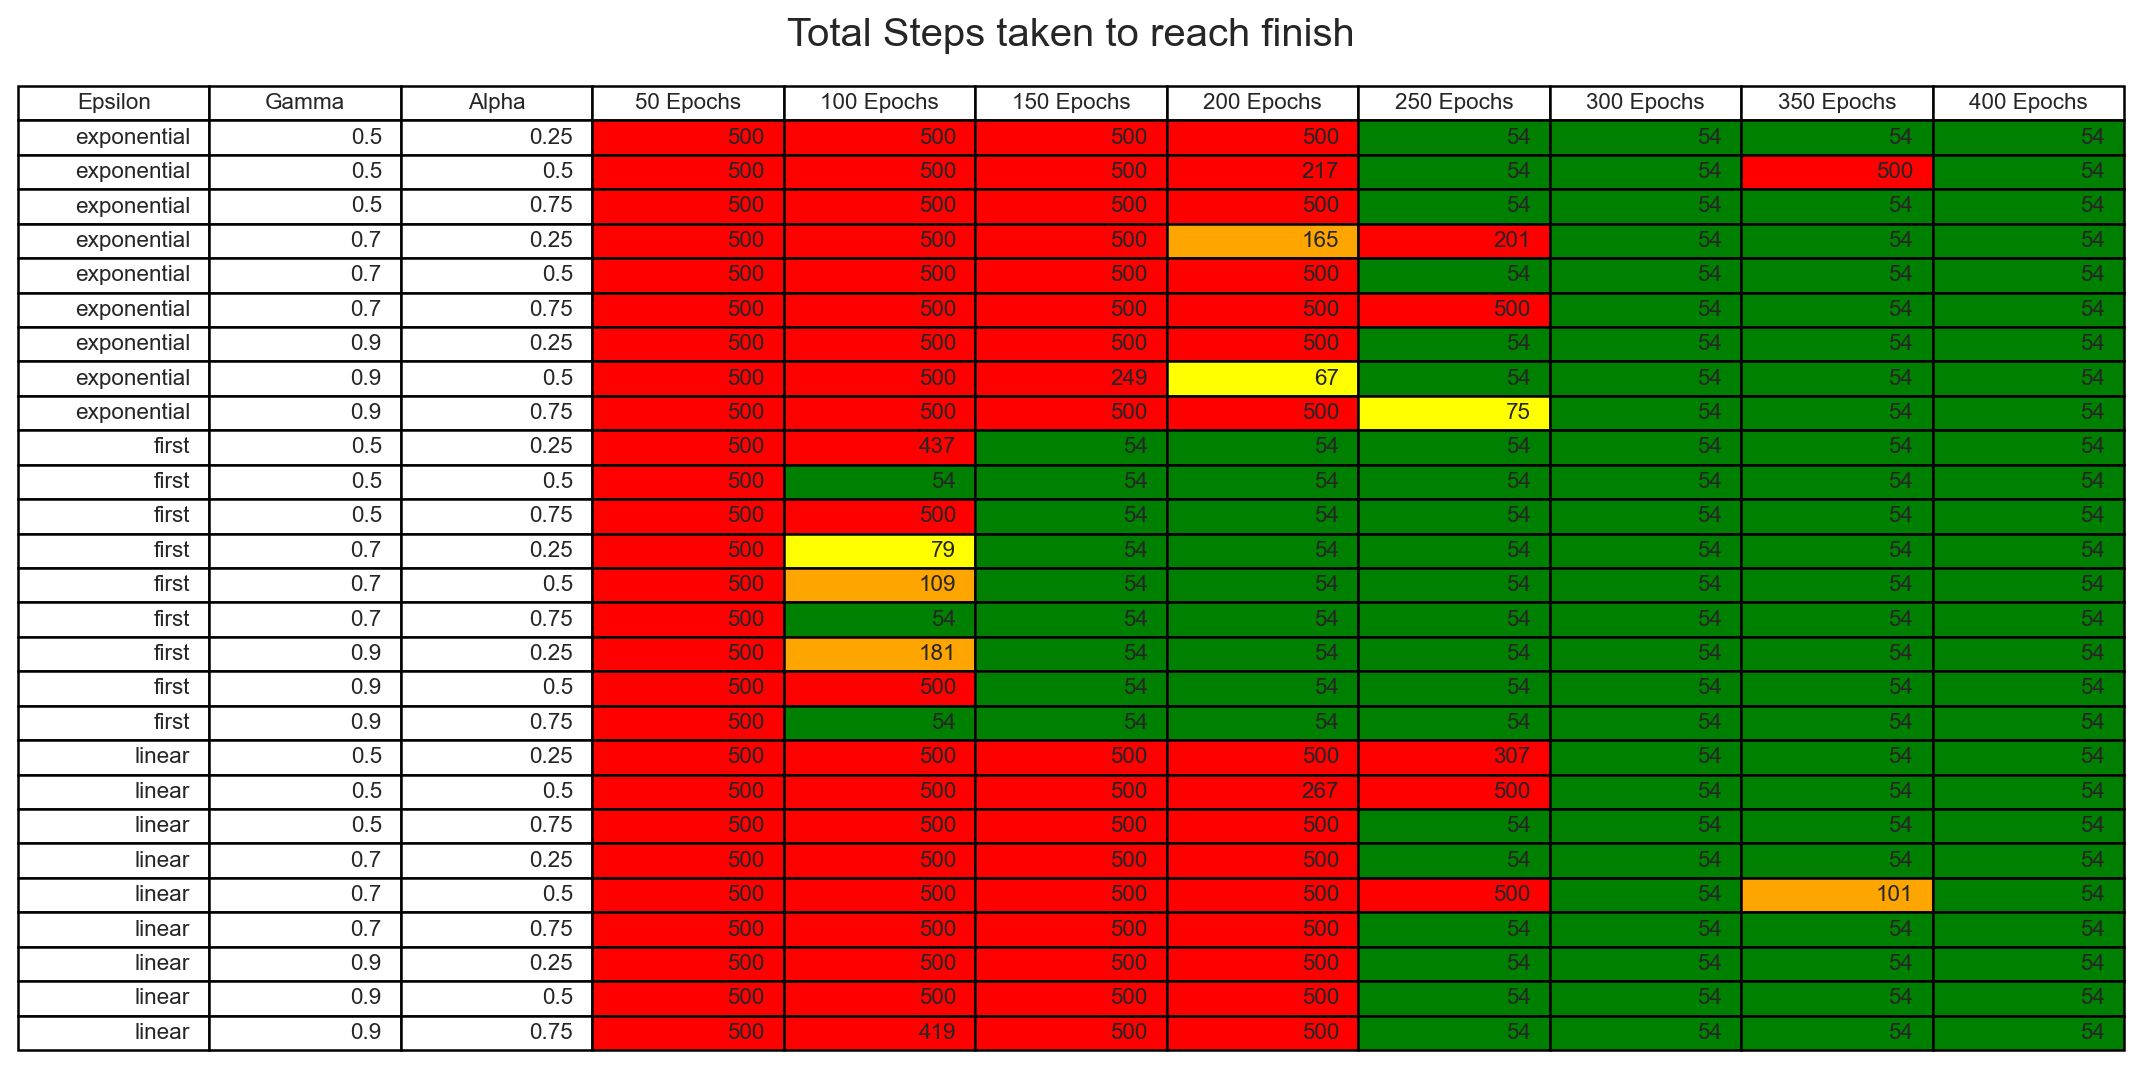

In [128]:
# Plot for total steps
fig, ax = plt.subplots(figsize=(12, 6), dpi=180)
columns = ["Epsilon", "Gamma", "Alpha", "50 Epochs", "100 Epochs", "150 Epochs", "200 Epochs", "250 Epochs" , "300 Epochs", "350 Epochs", "400 Epochs"]
colors = []
for entry in steps_plt_array:
    colors.append(["white", "white", "white"] + [color_palete(val, typ="steps") for val in entry[3:]])


fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=steps_plt_array, colLabels=columns, loc='center', cellColours=colors)

fig.suptitle("Total Steps taken to reach finish", fontsize=16)
fig.tight_layout()
plt.show()

<font color="blue"><h4>Results Analysis | Part 1</h4></font>
In the table above, we can see the total steps the agent needed to the level for every hyperparameter combination split into different training lengths (Number of epochs). If the agent needed 500 steps in the simualtion, this means he has not reach the finish and the game has reacht its turn limit set at 500 steps. On the other hand 54 is the best accievable value when when avoiding traps. <br>

We can see, than no model was able to learn the level in just 50 epochs. Every agent here failed to find the finish. After 400 training epochs in contrast every agent was able to reach the finish with the optimal number of steps. This result is in accordance with our sample testing where we discovered that any sensible combination eventually reaches the optimal solution <br>
One aspect we can observe is that the "first" epsilon decay method consistently performed much better than the exponential or linear method. This discovery was very interesting and was not what we expected in the beginning as we assumed exponetial decay would perform the best. Uppon further investigation, we think that the reason why first performes so much better is that it has more experimenting in general and therefore finds the finish sooner. Our assumption is that because the other methods experiment less, they will get stuck at the local optimum of just avoiding traps much longer than the "first" method. <br>

The Hyperparameters gamma and alpha seem to not make much difference. We can observe a slight tendency to a higher gamma value being better as most configurations within one epsilon decay type reach the optimal soluting one epoch category sooner than those with low values. This however could also be caused by differences in the exploration due to randomness.<br>
Changing alpha seems to have had no effect in this test setup.<br>

Interestingly there were two instances with a training length of 350 epochs where the model was not performing well despite the same model performing optimal with less training epochs in the run before. We attribute this to "unlucky" exploration randomness. <br>

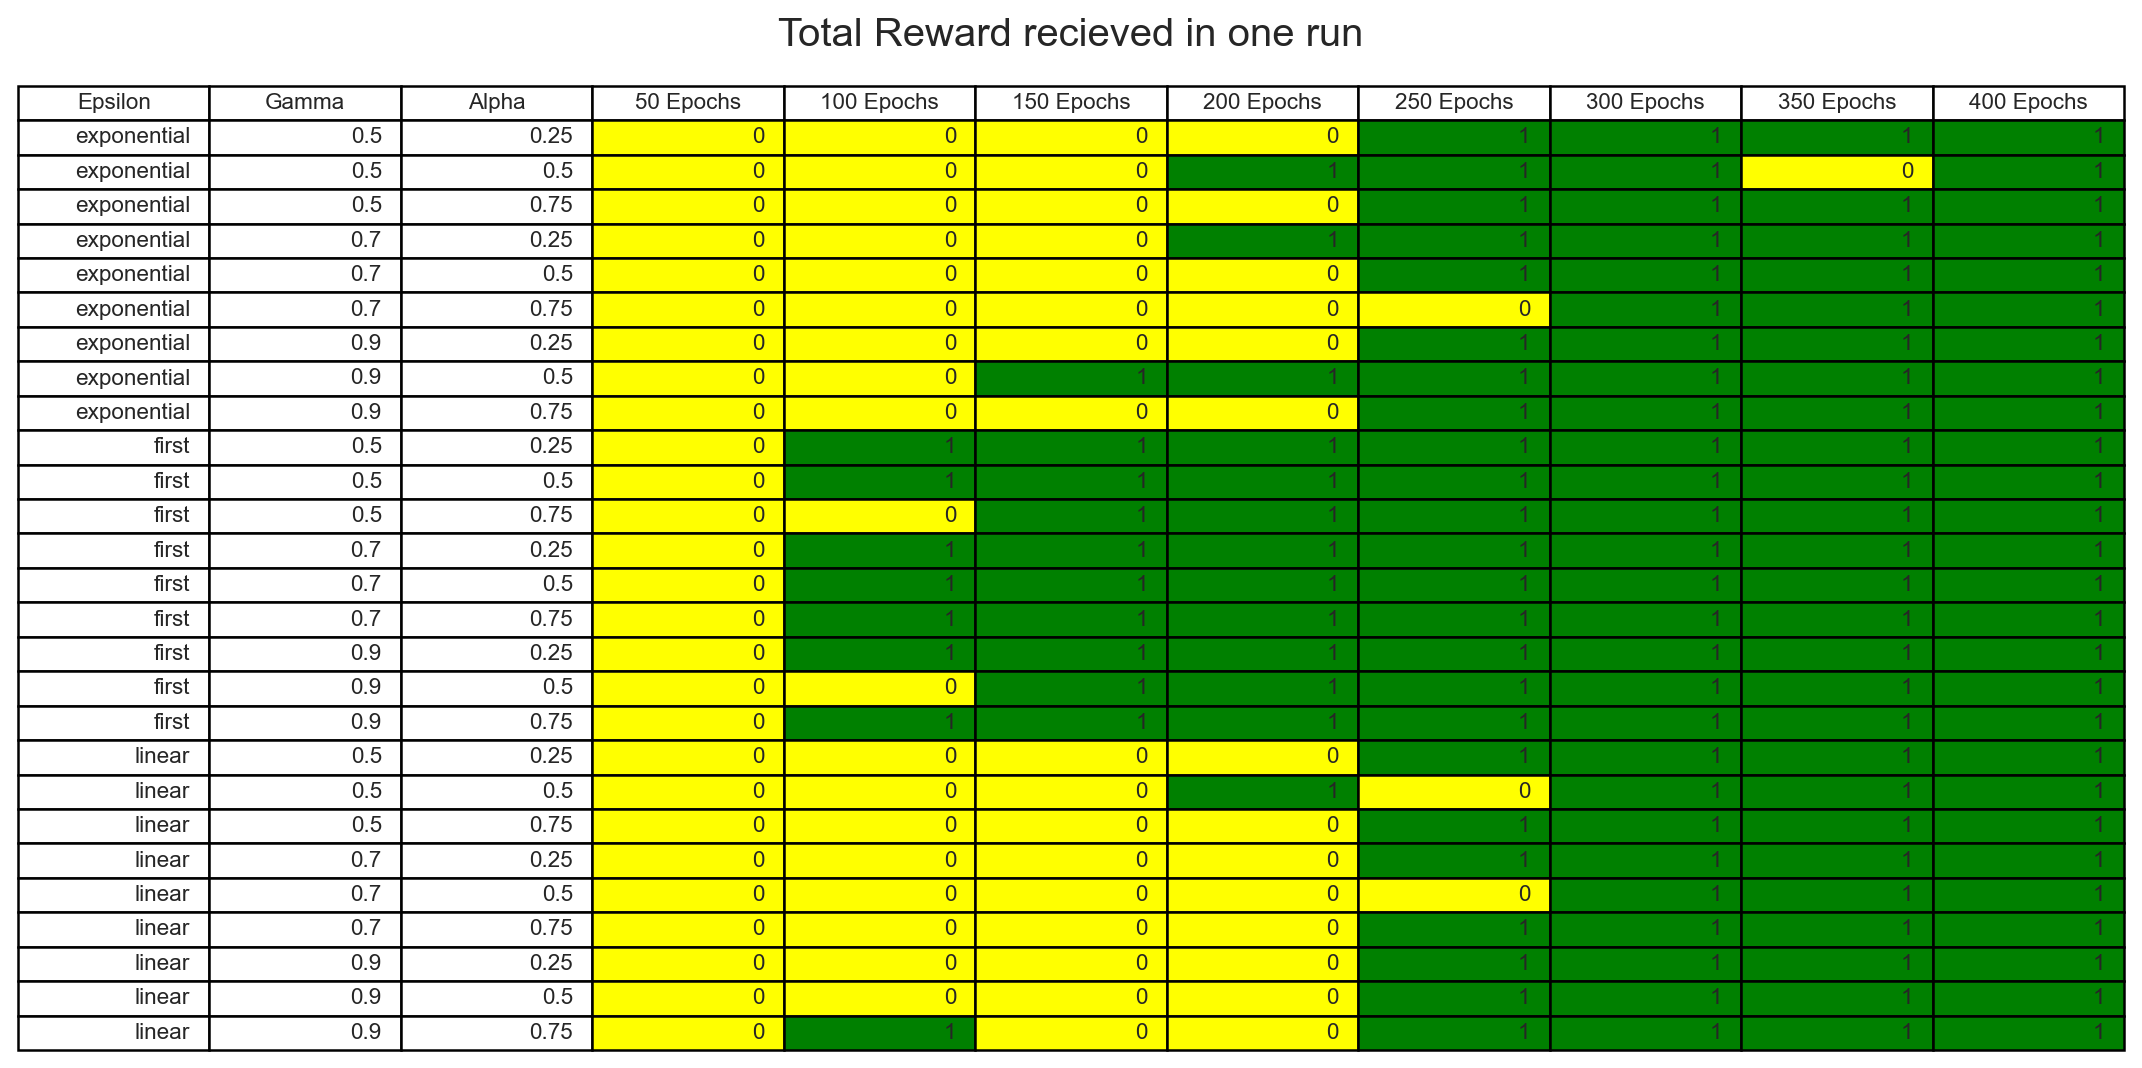

In [129]:
# Plot for total reward
fig, ax = plt.subplots(figsize=(12, 6), dpi=180)
columns = ["Epsilon", "Gamma", "Alpha", "50 Epochs", "100 Epochs", "150 Epochs", "200 Epochs", "250 Epochs" , "300 Epochs", "350 Epochs", "400 Epochs"]
colors = []
for entry in rewards_plt_array:
    colors.append(["white", "white", "white"] + [color_palete(val, typ="reward") for val in entry[3:]])

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=rewards_plt_array, colLabels=columns, loc='center', cellColours=colors)

fig.suptitle("Total Reward recieved in one run", fontsize=16)
fig.tight_layout()
plt.show()

<font color="blue"><h4>Results Analysis | Part 2</h4></font>

The same plot was also created for the total reward and can be seen above. We can see a similar structure to the table before where the "first" method performed the best. We can also see that every model was able to avoid traps very early on. Every hyperparameter combination was able to not get a single negative reward even after just 50 epochs which means the learned to avoid traps very soon. This discovery could back up our assumtion from before that the exponential and linear decay methods get stuck at the local optimum of just avoiding traps.

**Conclusion:**<br>
This experiment showed us that the "first" approach to epsilon decay is the best method for q learning in the context of maze solving. Especially for level 1 of gridworlds. It would be interesting to see if the result would differ with different levels. We, however, assume that because of the similar structure and Q-table, the results would be similar. Another aspect that could be expanded uppon is testing more values for each hyperparameter. Because of time and plotting constraints, we decided to keep the scope relatively small and ended up "only" running 216 trainings for differnt combinations. In a larger experiment the assumption of always finding the optimal solution could be testet further.

<font color="blue"><h3>Final Thoughts</h3></font>
We learned in this notebook, that q-learning can be successfully applied to solving the levels of gridworld. However, we felt that the environment was somewhat limiting. There are only 3 levels and they always have the same structure. What would happen if one would try to train an agent on general maze solving where the level and its features are randomized each time?. Based on what we learned, we think that for this task idea, the Q-table would need to be altered. Currently it has information about a concrete location in the maze, but if the maze was randomized each time, we assume that this approach would not work because the value of beeing in a specific point in the maze would always be different. We think that changing the Q table to containing information about cells near to the agent would make more sense in this case. The agent could have information on what type of cell is in front and to the sides of it and could learn to take actions based on that information. We think that with this approach, one could create a general maze solving agent. 